## Chapter 03. 평가

#### 분류의 성능 평가 지표
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

### 01. 정확도

- 정확도(Accuracy) = (예측 결과가 동일한 데이터 건수)/(전체 예측 데이터 건수)
- 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 직관적인 지표
- 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 하나만을 가지고 성능을 평가하지 않음

#### 1) 타이타닉 데이터 세트

In [7]:
from sklearn.base import BaseEstimator
# Customized 형태의 estimator 생성 가능

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None): 
        pass
    # predicxt() 메서드는 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1) )
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

# transform_features

def fillna(df):
    df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

from sklearn import preprocessing
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() 
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터 재로딩, 가공, 학습/테스트 데이터 분할
titanic_df = pd.read_csv('C:/Users/Jaewon/ESAA/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [13]:
# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

import numpy as np
mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


- 단순한 알고리즘으로 예측을 하더라도 정확도 결과가 꽤 높은 수치가 나옴
- 정확도는 불균형한 레이블값 분포에서 ML 모델 성능 판단시 적합한 평가 지표가 아님

#### 2) MNIST 데이터 세트
- 모든 데이터를 False(0)으로 예측하는 분류기를 이용해 정확도를 측정시 90%의 높은 수치가 나옴
- (단순히 predict() 결과를 np.zeros()로 모두 0값으로 반환함에도)

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, Y):
        pass
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X),1), dtype=bool) 

# 사이킷런 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [2]:
# 불균형한 레이블 데이터 분포도 확인
# 불균형한 레이블 데이터의 분포도 확인
print("레이블 테스트 세트 크기: ", y_test.shape)
print("테스트 세트의 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print("모든 예측을 0으로 하여도 정확도는: {:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기:  (450,)
테스트 세트의 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


### 02. 오차 행렬
- 이진 분류의 예측 오류가 얼마인지와, 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
-  4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄
- 4분면의 왼쪽, 오른쪽을 예측된 클래스 값을 기준으로 Negative와 Positive로 분류하고 4분면의 위, 아래를 실제 클래스 값 기준으로 Negative와 Positive로 분류
 - TN : 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
 - FP : 예측값을 Positive 값 1로 에측했는데 실제 값은 Negative 값 0
 - FN : 예측값을 Negative 값 0으로 예측했고 실제 값은 Positive 값 1
 - TP : 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1

In [3]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

- 출력된 오차 행렬은 ndarray 형태
- 값들을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음
- 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Positive 보다는 Negative로 예측 정확도가 높아지는 경향이 발생

### 03. 정밀도와 재현율
- Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
 - 정밀도 = TP / (FP + TP) : 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율, 양성 예측도
 - 재현율 = TP / (FN + TP) : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율, 민감도, TPR(True Positivde Rate)
- 재현율이 중요 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 정밀도가 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 재현율과 정밀도 모두 TP를 높이는데 동일하게 초점을 맞추지만, 재현율은 FN을 낮추는데 정밀도는 FP를 낮추는데 초점

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [10]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측하고 각 평가 수행
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('C:/Users/Jaewon/ESAA/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)
#정밀도에 비해 재현율이 낮음

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율:0.7869


#### 01. 정밀도/재현율 트레이드오프
- 정밀도와 재현율은 상호보완적 평가지표로 한쪽을 강제로 높이면 다른 한쪽의 수치가 떨어짐
- *predict_proba()* : 개별 데이터별로 예측 확률 반환
 - 학습이 완료된 사이킷런 Classifier 객체에서 호출 가능
 - 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환
 - 개별클래스의 예측확률을 ndarray, m(입력값 레코드수)xn(클래스값유형) 형태로 반환, 각 열은 개별 클래스의 예측 확률
 - 이진 분류에서 반환되는 ndarray는 첫번째 칼럼이 클래스 값 0에 대한, 두번째 칼럼이 클래스 값 1에 대한 예측 확률

In [11]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'. format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
 [[0.46154693 0.53845307]
 [0.87860046 0.12139954]
 [0.87725098 0.12274902]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46154693 0.53845307 1.        ]
 [0.87860046 0.12139954 0.        ]
 [0.87725098 0.12274902 0.        ]]


- 사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 수치를 상호 보완적으로 조정할 수 있음
- threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 객체로 생성, 생성된 Binarizer 객체의 fit_transform()메서드를 이용해 넘파이 ndarray를 이용하면 지정된 threshold보다 같거나 작으면 0값으로, 크면 1값으로 변환해 반환

In [12]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임곗값임
custom_threshold = 0.5

#predict_proba() 반환값의 두번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율:0.7869


In [14]:
#threshold 값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
# 재현율 값이 올라가고 정밀도가 떨어짐
# 임곗값 값을 낮출수록 True값이 많아져 재현율이 올라가고 정밀도가 떨어짐

오차행렬
[[99 19]
 [10 51]]
정확도 : 0.8380, 정밀도 : 0.7286, 재현율:0.8361


In [15]:
# 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표를 조사
#테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.44, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #threshold list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)
# 0.45가 0.5와 비교해서 정확도는 동일하고 정밀도는 약간 떨어졌으나 재현율이 올라 가장 적당해보임

임곗값: 0.44
오차행렬
[[101  17]
 [ 11  50]]
정확도 : 0.8436, 정밀도 : 0.7463, 재현율:0.8197
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율:0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율:0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율:0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율:0.7377


- 사이킷런 precision_recall_curve()
 - 입력 파라미터 : y_true, probas_pred (Positive 칼럼의 예측 확률 배열)
 - 반환 값 : 임곗값별 정밀도, 재현율

In [16]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 stepdmfh cncnf
thr_index = np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


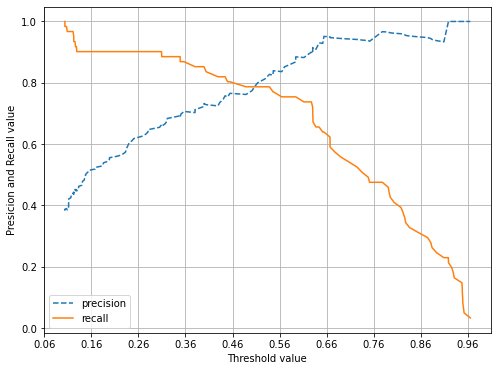

In [18]:
# 정밀도와 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # treshold ndarray와 threshold에 따른 정밀도, 제현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    #X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scaledmf 0.1단위로 변경
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Presicion and Recall value')
    plt.legend()
    plt.grid()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])
# 임곗값이 낮을수록 많은수의 양성 예측으로 인해 재현율값이 극도로 높아지고 정밀도 값이 극도로 낮아짐
# 임곗값 약 0.45 지점에서 재현율과 정밀도가 비슷해짐

#### 02) 정밀도와 재현율의 맹점
- 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 함
- 정밀도가 100%가 되는 법 : 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
- 재현율이 100%가 되는 법 : 모든 환자를 Positive로 예측
- => 정밀도와 재현율 성능수치 중 어느 한쪽만 참조하면 극단적인 수치조작 가능. 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있음

### 04. F1 스코어
- 정밀도와 재현율을 결합한 지표, 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐
- F1 = 2/(1/recall+1/precision) = 2x(precisionxrecall)/(precision+recall)

In [19]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [20]:
# 임곗값 0.4~0.6별 정확도, 정밀도, 재현율, F1스코어
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # F1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)
# 임곗값이 0.6일 때 가장 좋은 값을 보여줌 하지만 재현율이 크게 감소

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도 : 0.8380, 정밀도 : 0.7286, 재현율:0.8361, F1 : 0.7786
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율:0.8033, F1 : 0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율:0.7869, F1 : 0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율:0.7541, F1 : 0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율:0.7377, F1 : 0.8036


### 05. ROC곡선과 AUC
- 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표
- ROC 곡선 
 - 수신자 판단 곡선
 - FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선 (FPR x TPR)
 - TNR (True Negative Rate) : 민감도(재현율)에 대응하는 지표, 특이성, 실제값 음성이 정확히 예측돼야 하는 수준
 - **FPR = FP/(FP+TN) = 1- TNR = 1-특이성**
 - ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어짐, 분류 결정 임곗값을 변경해 - roc_curve() API
 - 입력 파라미터 : y_true, y_score(predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨)
 - 반환 값 : FPR(array), TPR(array), tresholds

In [21]:
from sklearn.metrics import roc_curve

# 레이블값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 스텝으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임곗값 : ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))
# 임곗값이 1에 가까운 갑세서 점점 작아지면서 FPR이 점점 커짐, FPR이 조금씩 커질 때 TPR은 가파르게 커짐

샘플 추출을 위한 임곗값 배열의 index 10개 :  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값 :  [0.97 0.65 0.63 0.56 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR: [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


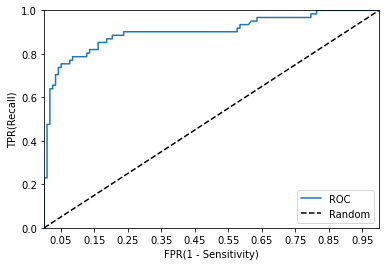

In [23]:
# ROC 곡선 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선 그림
    plt.plot([0,1],[0,1],'k--', label='Random')

    #FPR X 축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

- 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정
- AUC 값은 곡선 및의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치
- AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수가 있는냐가 관건
- 가운데 대각선 직선은 랜덤 이진 분류 AUC값(0.5). 보통의 분류는 0.5 이상의 AUC값

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

print(confusion_matrix(y_test,pred))
print("정확도:", np.round(accuracy_score(y_test,pred),4))
print("정밀도:", np.round(precision_score(y_test,pred),4))
print("재현율:", np.round(recall_score(y_test,pred),4))

[[104  14]
 [ 13  48]]
정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869


In [27]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))